In [1]:
import os
import numpy as np
import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.backends.cudnn as cudnn
# from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from utils.mask_functions import *
from glob import glob
import pydicom
import cv2

import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.losses import binary_crossentropy

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

W0819 23:22:19.448531 140194163803904 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0819 23:22:19.449733 140194163803904 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0819 23:22:19.450453 140194163803904 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0819 23:22:20.003327 140194163803904 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1',
 '/job:localhost/replica:0/task:0/device:GPU:2',
 '/job:localhost/replica:0/task:0/device:GPU:3']

In [3]:
def plot_pixel_array(data, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.show()
    
def plot_pixel_array_overlay(data, label, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.imshow(label, alpha=.3)
    plt.show()

### Load Train Data

In [4]:
train_fns = glob('./data/dicom-images-train/*/*/*.dcm')
rles_df = pd.read_csv('./data/train-rle.csv', index_col='ImageId')
rles_df.columns

Index([' EncodedPixels'], dtype='object')

In [5]:
im_height = 1024
im_width = 1024
X_train = np.zeros((len(train_fns), im_height, im_width, 1), dtype=np.float32)
Y_train = np.zeros((len(train_fns), im_height, im_width, 1), dtype=np.float32)
has_pneumothorax = []

In [6]:
for n, fn in enumerate(train_fns):
    dcm = pydicom.dcmread(fn)
    X_train[n] = np.expand_dims(dcm.pixel_array/255, axis=2)
    encoded_pixels = rles_df.loc[dcm.SOPInstanceUID][' EncodedPixels']
    if '-1' in encoded_pixels:
        Y_train[n] = np.zeros((1024, 1024, 1))
    else:
        has_pneumothorax.append(n)
        if type(encoded_pixels) == str: # Single Mask
            Y_train[n] = np.expand_dims(rle2mask(encoded_pixels, 1024, 1024).T, axis=2)
        else: # Multiple masks
            Y_train[n] = np.zeros((1024, 1024, 1))
            for x in encoded_pixels:
                Y_train[n] = Y_train[n] + np.expand_dims(rle2mask(x, 1024, 1024).T, axis=2)
            #plot_pixel_array_overlay(X_train[n], Y_train[n])
            #break
# Scale X_train
Y_train[Y_train > 0] = 1.
print('has_pneumothorax:', len(has_pneumothorax), '/', len(X_train))
print('Done.')

has_pneumothorax: 2379 / 10675
Done.


### Visualize

<Figure size 432x288 with 0 Axes>

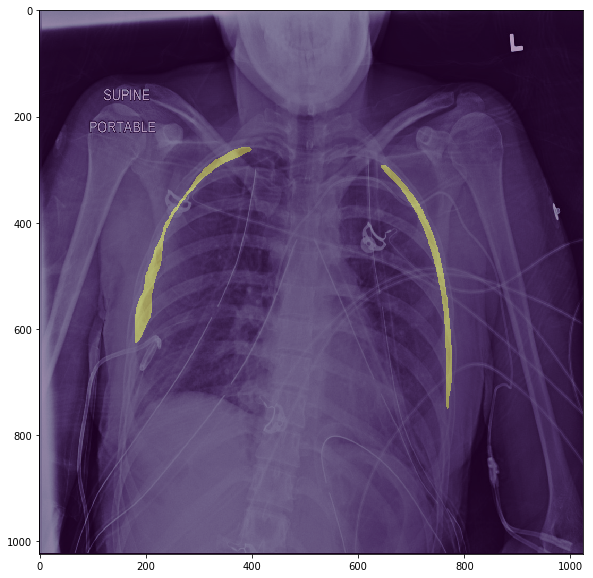

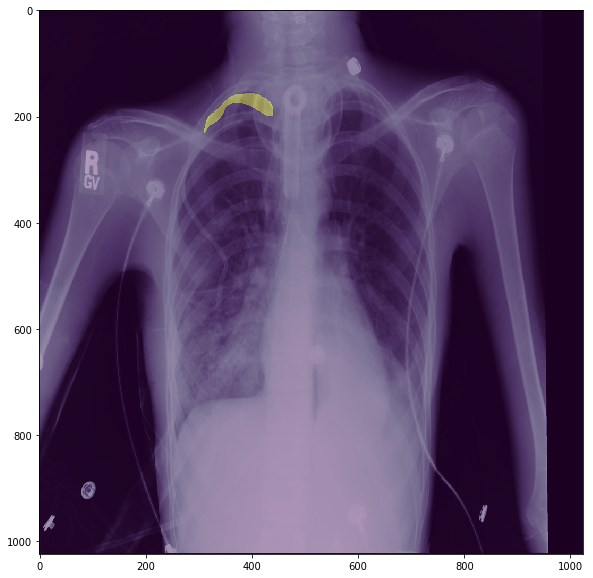

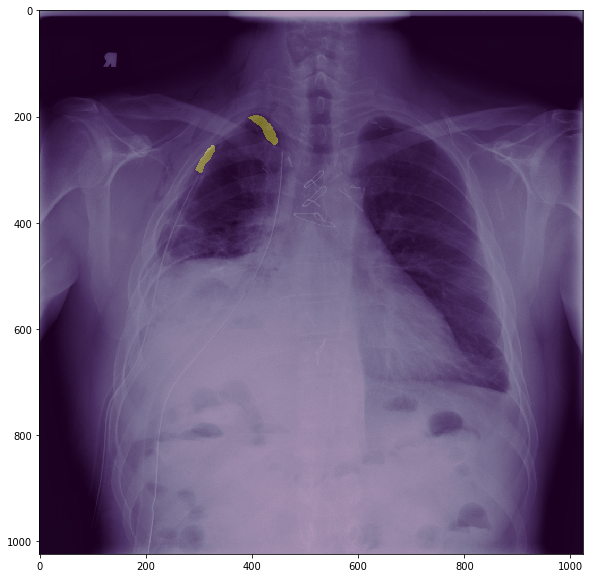

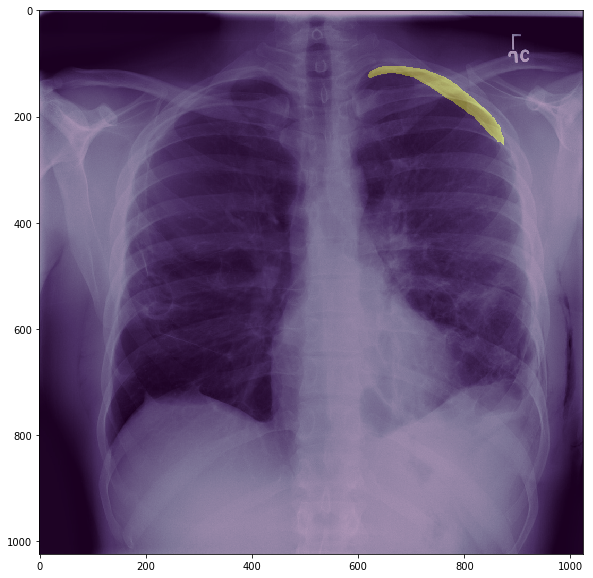

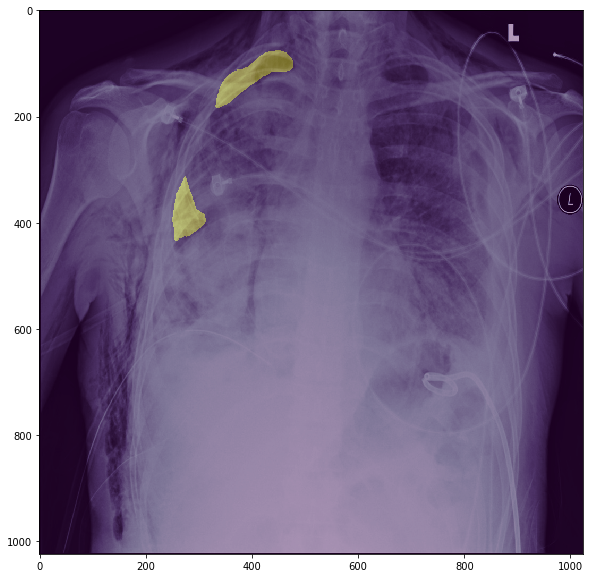

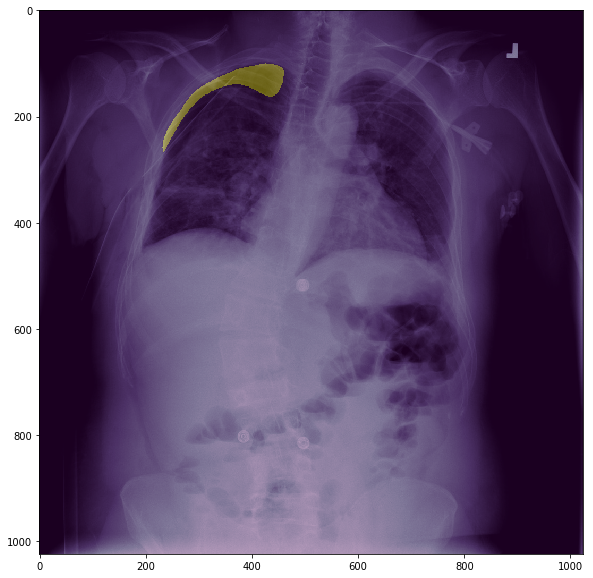

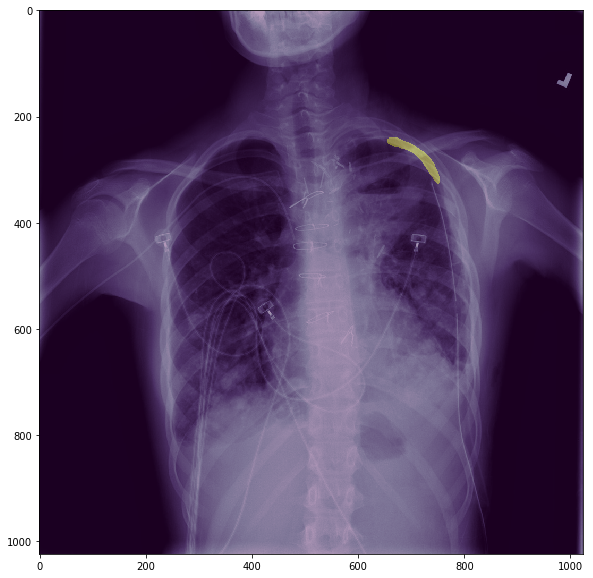

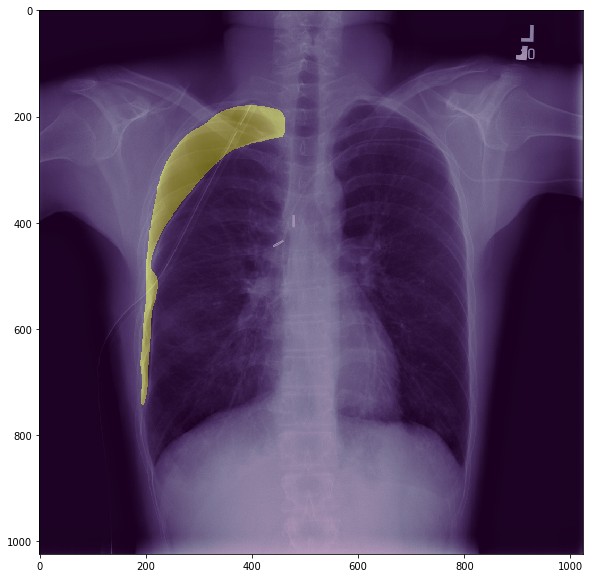

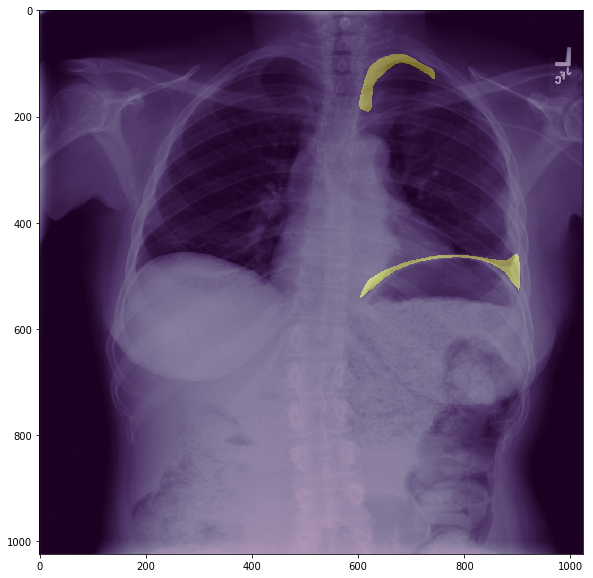

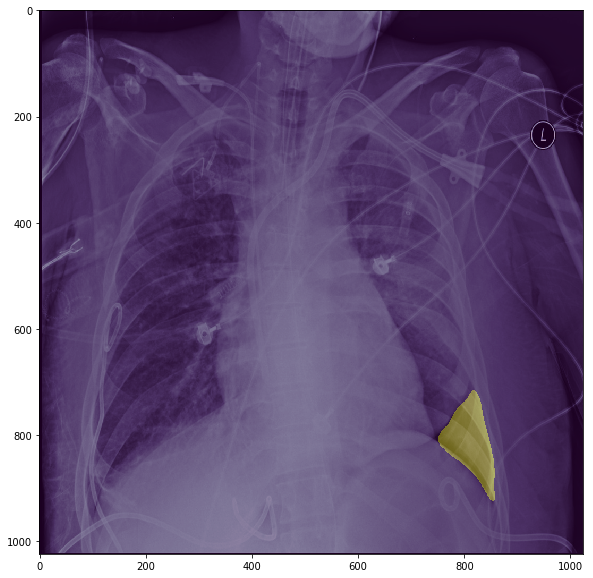

In [7]:
plt.clf()
for i, n in enumerate(has_pneumothorax[0:10]):
    plt.figure(figsize=(10, 10))
    plt.imshow(X_train[n].squeeze(), cmap=plt.cm.bone)
    plt.imshow(Y_train[n].squeeze(), alpha=.4)
    plt.show()

### TODO: Patching

### Loss

In [8]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

### Network

In [9]:
'''
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.losses import binary_crossentropy

import tensorflow as tf
'''

'\nfrom keras.models import Model\nfrom keras.layers import Input\nfrom keras.layers.convolutional import Conv2D, Conv2DTranspose\nfrom keras.layers.pooling import MaxPooling2D\nfrom keras.layers.merge import concatenate\nfrom keras import backend as K\nfrom keras.callbacks import ModelCheckpoint\nfrom keras.losses import binary_crossentropy\n\nimport tensorflow as tf\n'

In [10]:
inputs = Input((None, None, 1))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

W0819 23:24:43.653492 140194163803904 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 23:24:43.674645 140194163803904 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0819 23:24:44.008119 140194163803904 deprecation_wrapper.py:119] From /opt/conda/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0819 23:24:44.034663 140194163803904 deprecation.py:323] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updatin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 8 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 8 584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 8 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [11]:
json_string = model.to_json()
open('./save/u-net.json', 'w').write(json_string)
checkpointer = ModelCheckpoint('./save/best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True, save_weights_only=False)

In [12]:
# im_height = 256
# im_width = 256
# X_train = X_train.reshape((-1, im_height, im_width, 1))
# Y_train = Y_train.reshape((-1, im_height, im_width, 1))
X_train.shape, Y_train.shape


((10675, 1024, 1024, 1), (10675, 1024, 1024, 1))

In [13]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1',
 '/job:localhost/replica:0/task:0/device:GPU:2',
 '/job:localhost/replica:0/task:0/device:GPU:3']

In [14]:
model.fit(X_train, Y_train, validation_split=.2, batch_size=16, epochs=2, callbacks=[checkpointer])

Train on 8540 samples, validate on 2135 samples
Epoch 1/2
8540/8540 [==============================] - 389s 46ms/step - loss: 0.0655 - dice_coef: nan - val_loss: 0.0548 - val_dice_coef: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.05482, saving model to ./save/best_weights.h5
Epoch 2/2
8540/8540 [==============================] - 381s 45ms/step - loss: 0.0477 - dice_coef: nan - val_loss: 0.0548 - val_dice_coef: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.05482


In [15]:
model.save_weights('./save/final_weights.h5', overwrite=True)

### Load Test Data

In [16]:
test_fns = glob('./data/dicom-images-test/*/*/*.dcm')

In [17]:
X_test = np.zeros((len(test_fns), im_height, im_width, 1), dtype=np.uint8)
test_ids = np.ndarray((len(test_fns)), dtype='object')

In [18]:
for n, fn in enumerate(test_fns):
    dcm = pydicom.dcmread(fn)
    X_test[n] = np.expand_dims(dcm.pixel_array, axis=2)
    test_ids[n] = dcm.SOPInstanceUID
print('Done.')

Done.


In [19]:
model.load_weights('./save/best_weights.h5')
preds = model.predict(X_test, batch_size=16)
print(preds.shape)

(1372, 1024, 1024, 1)


In [20]:
#preds = preds.reshape((-1, 1024, 1024, 1))

### Visualize Predictions

<Figure size 432x288 with 0 Axes>

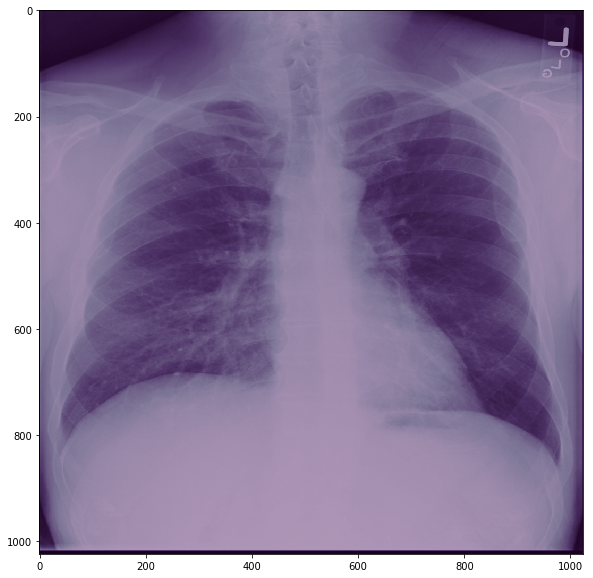

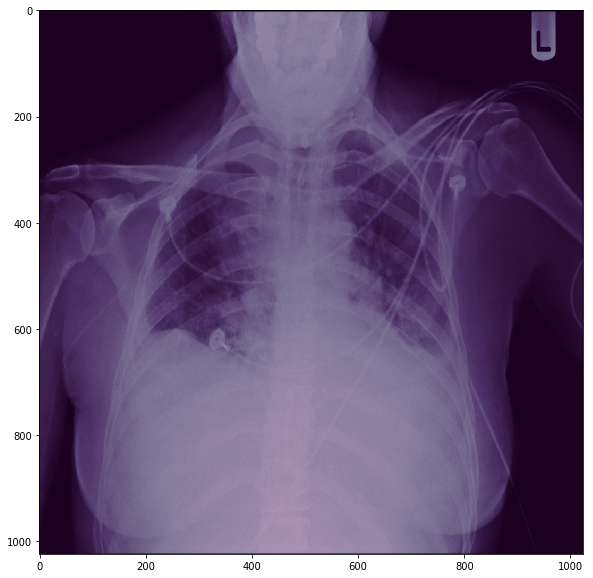

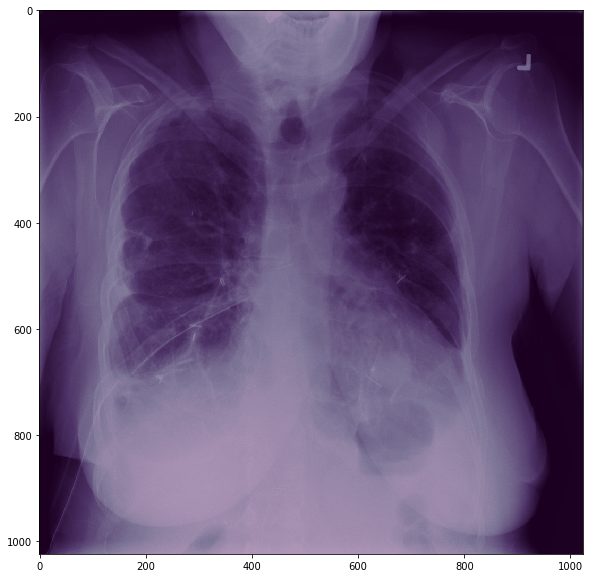

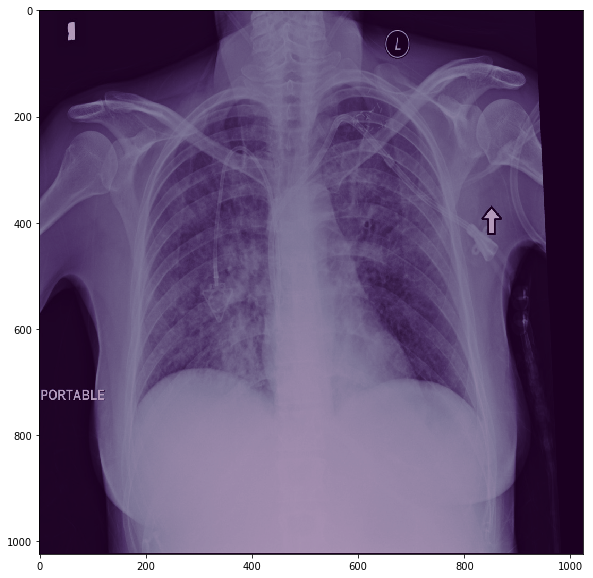

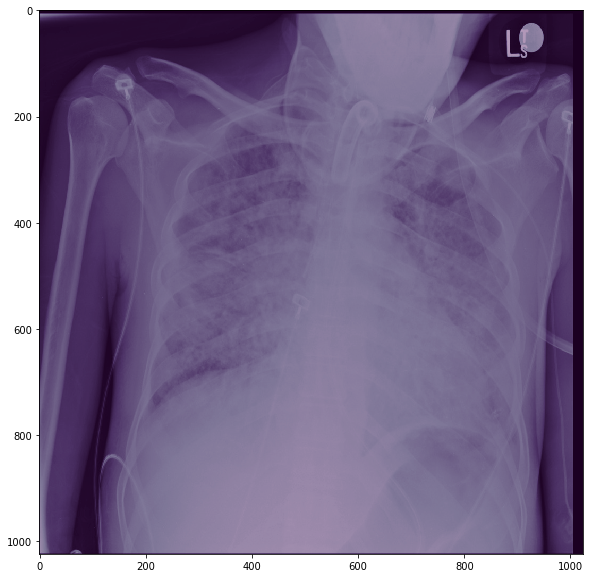

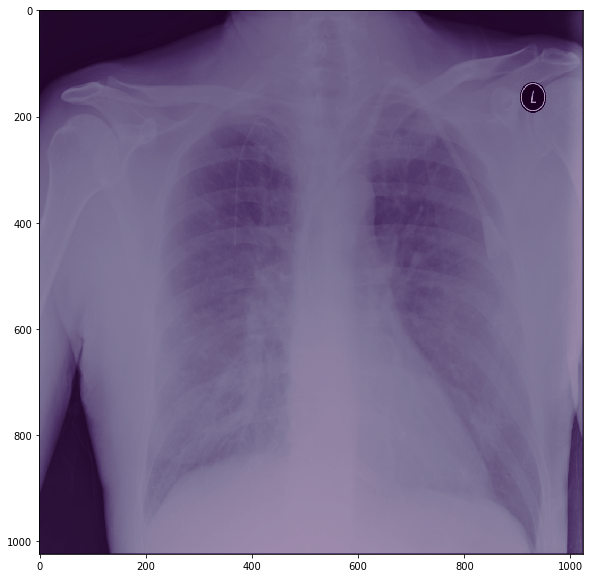

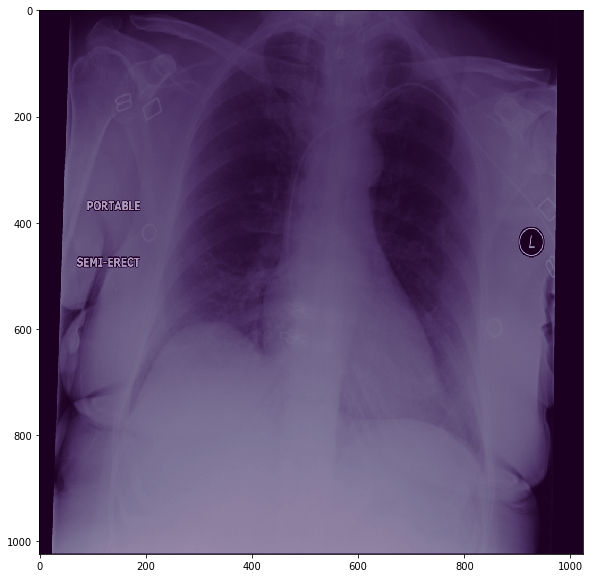

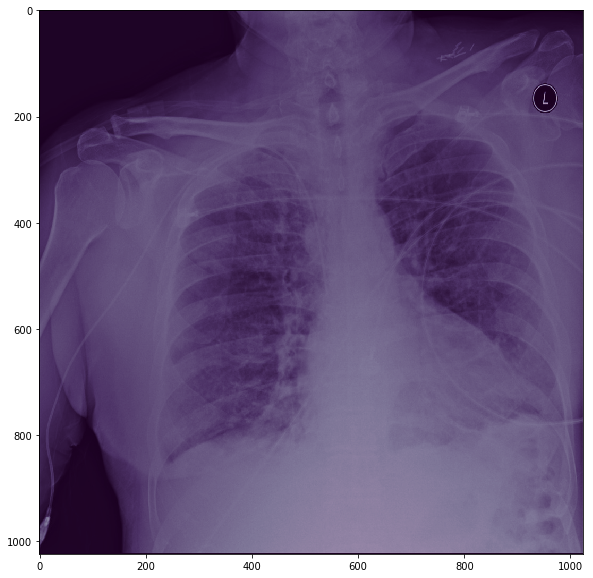

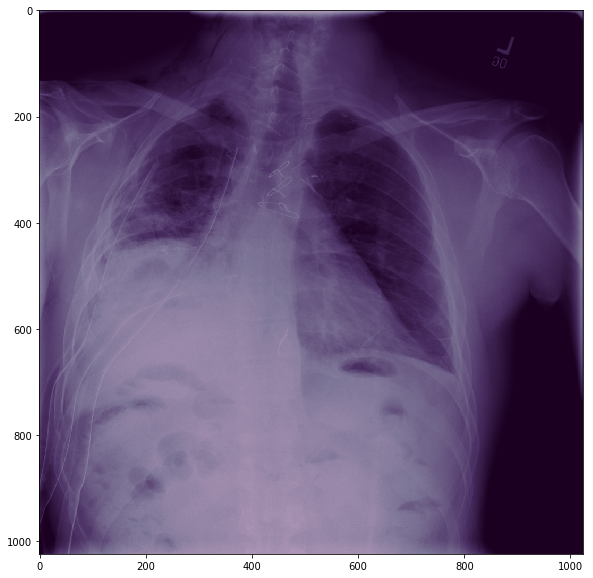

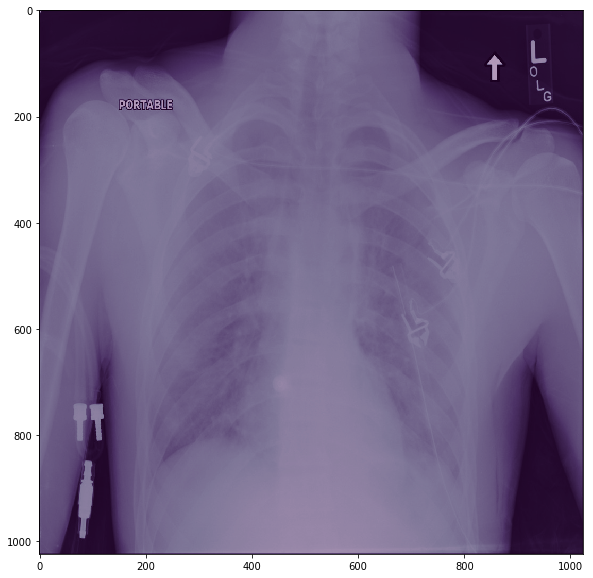

In [21]:
preds = preds.squeeze()
plt.clf()
for n in range(0, 10):
    plt.figure(figsize=(10, 10))
    plt.imshow(X_test[n].squeeze(), cmap=plt.cm.bone)
    plt.imshow(preds[n], alpha=.4)
    plt.show()

In [22]:
preds[preds[0].max() > 0]

array([], shape=(0, 1372, 1024, 1024), dtype=float32)

### Generate Submission

In [23]:
rles = []
threshold = 0.3
for im in preds:
    im = im > threshold
    im = (im.T*255).astype(np.uint8)  
    rles.append(mask2rle(im, 1024, 1024))

In [24]:
sub_df = pd.DataFrame({'ImageId': test_ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

ImageId EncodedPixels
0  1.2.276.0.7230010.3.1.4.8323329.6212.151787519...            -1
1  1.2.276.0.7230010.3.1.4.8323329.6670.151787519...            -1
2  1.2.276.0.7230010.3.1.4.8323329.5868.151787519...            -1
3  1.2.276.0.7230010.3.1.4.8323329.6363.151787519...            -1
4  1.2.276.0.7230010.3.1.4.8323329.6627.151787519...            -1

In [25]:
sub_df.to_csv('submission.csv', index=False)

In [26]:
sub_df.loc[sub_df.EncodedPixels == '-1']

ImageId EncodedPixels
0     1.2.276.0.7230010.3.1.4.8323329.6212.151787519...            -1
1     1.2.276.0.7230010.3.1.4.8323329.6670.151787519...            -1
2     1.2.276.0.7230010.3.1.4.8323329.5868.151787519...            -1
3     1.2.276.0.7230010.3.1.4.8323329.6363.151787519...            -1
4     1.2.276.0.7230010.3.1.4.8323329.6627.151787519...            -1
5     1.2.276.0.7230010.3.1.4.8323329.6448.151787519...            -1
6     1.2.276.0.7230010.3.1.4.8323329.6015.151787519...            -1
7     1.2.276.0.7230010.3.1.4.8323329.6556.151787519...            -1
8     1.2.276.0.7230010.3.1.4.8323329.6602.151787519...            -1
9     1.2.276.0.7230010.3.1.4.8323329.6523.151787519...            -1
10    1.2.276.0.7230010.3.1.4.8323329.6375.151787519...            -1
11    1.2.276.0.7230010.3.1.4.8323329.6453.151787519...            -1
12    1.2.276.0.7230010.3.1.4.8323329.6296.151787519...            -1
13    1.2.276.0.7230010.3.1.4.8323329.6612.151787519...            -1
14    1.2.276.0.7230010.3.1.4.8323329.682.1517875164...            -1
15    1.2.276.0.7230010.3.1.4.8323329.6215.151787519...            -1
16    1.2.276.0.7230010.3.1.4.8323329.6309.151787519...            -1
17    1.2.276.0.7230010.3.1.4.8323329.6770.151787520...            -1
18    1.2.276.0.7230010.3.1.4.8323329.6707.151787519...            -1
19    1.2.276.0.7230010.3.1.4.8323329.6045.151787519...            -1
20    1.2.276.0.7230010.3.1.4.8323329.6694.151787519...            -1
21    1.2.276.0.7230010.3.1.4.8323329.6026.151787519...            -1
22    1.2.276.0.7230010.3.1.4.8323329.6175.151787519...            -1
23    1.2.276.0.7230010.3.1.4.8323329.6687.151787519...            -1
24    1.2.276.0.7230010.3.1.4.8323329.6568.151787519...            -1
25    1.2.276.0.7230010.3.1.4.8323329.5853.151787519...            -1
26    1.2.276.0.7230010.3.1.4.8323329.6958.151787520...            -1
27    1.2.276.0.7230010.3.1.4.8323329.6502.151787519...            -1
28    1.2.276.0.7230010.3.1.4.8323329.6040.151787519...            -1
29    1.2.276.0.7230010.3.1.4.8323329.5865.151787519...            -1
...                                                 ...           ...
1342  1.2.276.0.7230010.3.1.4.8323329.6143.151787519...            -1
1343  1.2.276.0.7230010.3.1.4.8323329.6634.151787519...            -1
1344  1.2.276.0.7230010.3.1.4.8323329.6750.151787519...            -1
1345  1.2.276.0.7230010.3.1.4.8323329.7026.151787520...            -1
1346  1.2.276.0.7230010.3.1.4.8323329.6986.151787520...            -1
1347  1.2.276.0.7230010.3.1.4.8323329.631.1517875163...            -1
1348  1.2.276.0.7230010.3.1.4.8323329.6165.151787519...            -1
1349  1.2.276.0.7230010.3.1.4.8323329.6575.151787519...            -1
1350  1.2.276.0.7230010.3.1.4.8323329.6567.151787519...            -1
1351  1.2.276.0.7230010.3.1.4.8323329.6623.151787519...            -1
1352  1.2.276.0.7230010.3.1.4.8323329.6006.151787519...            -1
1353  1.2.276.0.7230010.3.1.4.8323329.6951.151787520...            -1
1354  1.2.276.0.7230010.3.1.4.8323329.6050.151787519...            -1
1355  1.2.276.0.7230010.3.1.4.8323329.6728.151787519...            -1
1356  1.2.276.0.7230010.3.1.4.8323329.6360.151787519...            -1
1357  1.2.276.0.7230010.3.1.4.8323329.6231.151787519...            -1
1358  1.2.276.0.7230010.3.1.4.8323329.6397.151787519...            -1
1359  1.2.276.0.7230010.3.1.4.8323329.6278.151787519...            -1
1360  1.2.276.0.7230010.3.1.4.8323329.6241.151787519...            -1
1361  1.2.276.0.7230010.3.1.4.8323329.6229.151787519...            -1
1362  1.2.276.0.7230010.3.1.4.8323329.6538.151787519...            -1
1363  1.2.276.0.7230010.3.1.4.8323329.5845.151787519...            -1
1364  1.2.276.0.7230010.3.1.4.8323329.6282.151787519...            -1
1365  1.2.276.0.7230010.3.1.4.8323329.6893.151787520...            -1
1366  1.2.276.0.7230010.3.1.4.8323329.6146.151787519...            -1
1367  1.2.276.0.7230010.3.1.4.8323329.6511.151787519...   